In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(phangorn)

devtools::load_all(".")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: ape
Loading ychr


## Process the genotypes into a table of human variable SNPs

In [2]:
highcov <- read_genotypes("spy1", "full", mindp = 3, maxdp = 0.975, var_only = TRUE)

In [3]:
pops <- read_info(highcov)

In [4]:
gt <- select(highcov, -c(chrom, pos, REF, ALT, ustishim))

In [5]:
head(gt)

spy1,chimp,a00,S_BedouinB_1,S_Turkish_1,S_French_1,S_Burmese_1,S_Thai_1,S_Finnish_2,S_Sardinian_1,S_Han_2,S_Dai_2,S_Punjabi_1,S_Saami_2,S_Papuan_2,S_Karitiana_1,S_Ju_hoan_North_1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NA,0,0,0,0,NA,0,0,0,0,0,0,0,0,0,0,0
NA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
freqs <- select(gt, -chimp) %>% rowMeans(na.rm = TRUE)

Keep only variable sites (excluding chimp-unique variants):

In [7]:
gt <- filter(gt, freqs > 0 & freqs < 1)

In [8]:
vcf <- filter(highcov, freqs > 0 & freqs < 1)

In [9]:
derived <- mutate_all(gt, ~ as.integer(.x != gt$chimp))

In [11]:
nrow(derived)

[1] 6095

### Load the alignment for building a tree

In [12]:
aln <- read.phyDat(here("data/fasta/all_modern_full.fa"), format = "fasta")
aln$ustishim <- NULL

tree <- NJ(dist.ml(aln))
tree$tip.label <- str_replace(tree$tip.label, "-", "_")

rooted_tree <- root(tree, outgroup = c("a00"), resolve.root = TRUE)

## Count MH contaminant SNPs using fixed African ancestral vs derived non-African sites

In [12]:
(outgroup <- filter(pops, pop == "Africa")$name)
(ingroup <- filter(pops, pop %in% c("WestEur", "EastEur"))$name)

[1] "S_Ju_hoan_North_1" "a00"

[1] "S_BedouinB_1"  "S_Turkish_1"   "S_French_1"    "S_Burmese_1"  
 [5] "S_Thai_1"      "S_Finnish_2"   "S_Sardinian_1" "S_Han_2"      
 [9] "S_Dai_2"       "S_Punjabi_1"   "S_Saami_2"     "S_Papuan_2"   
[13] "S_Karitiana_1"

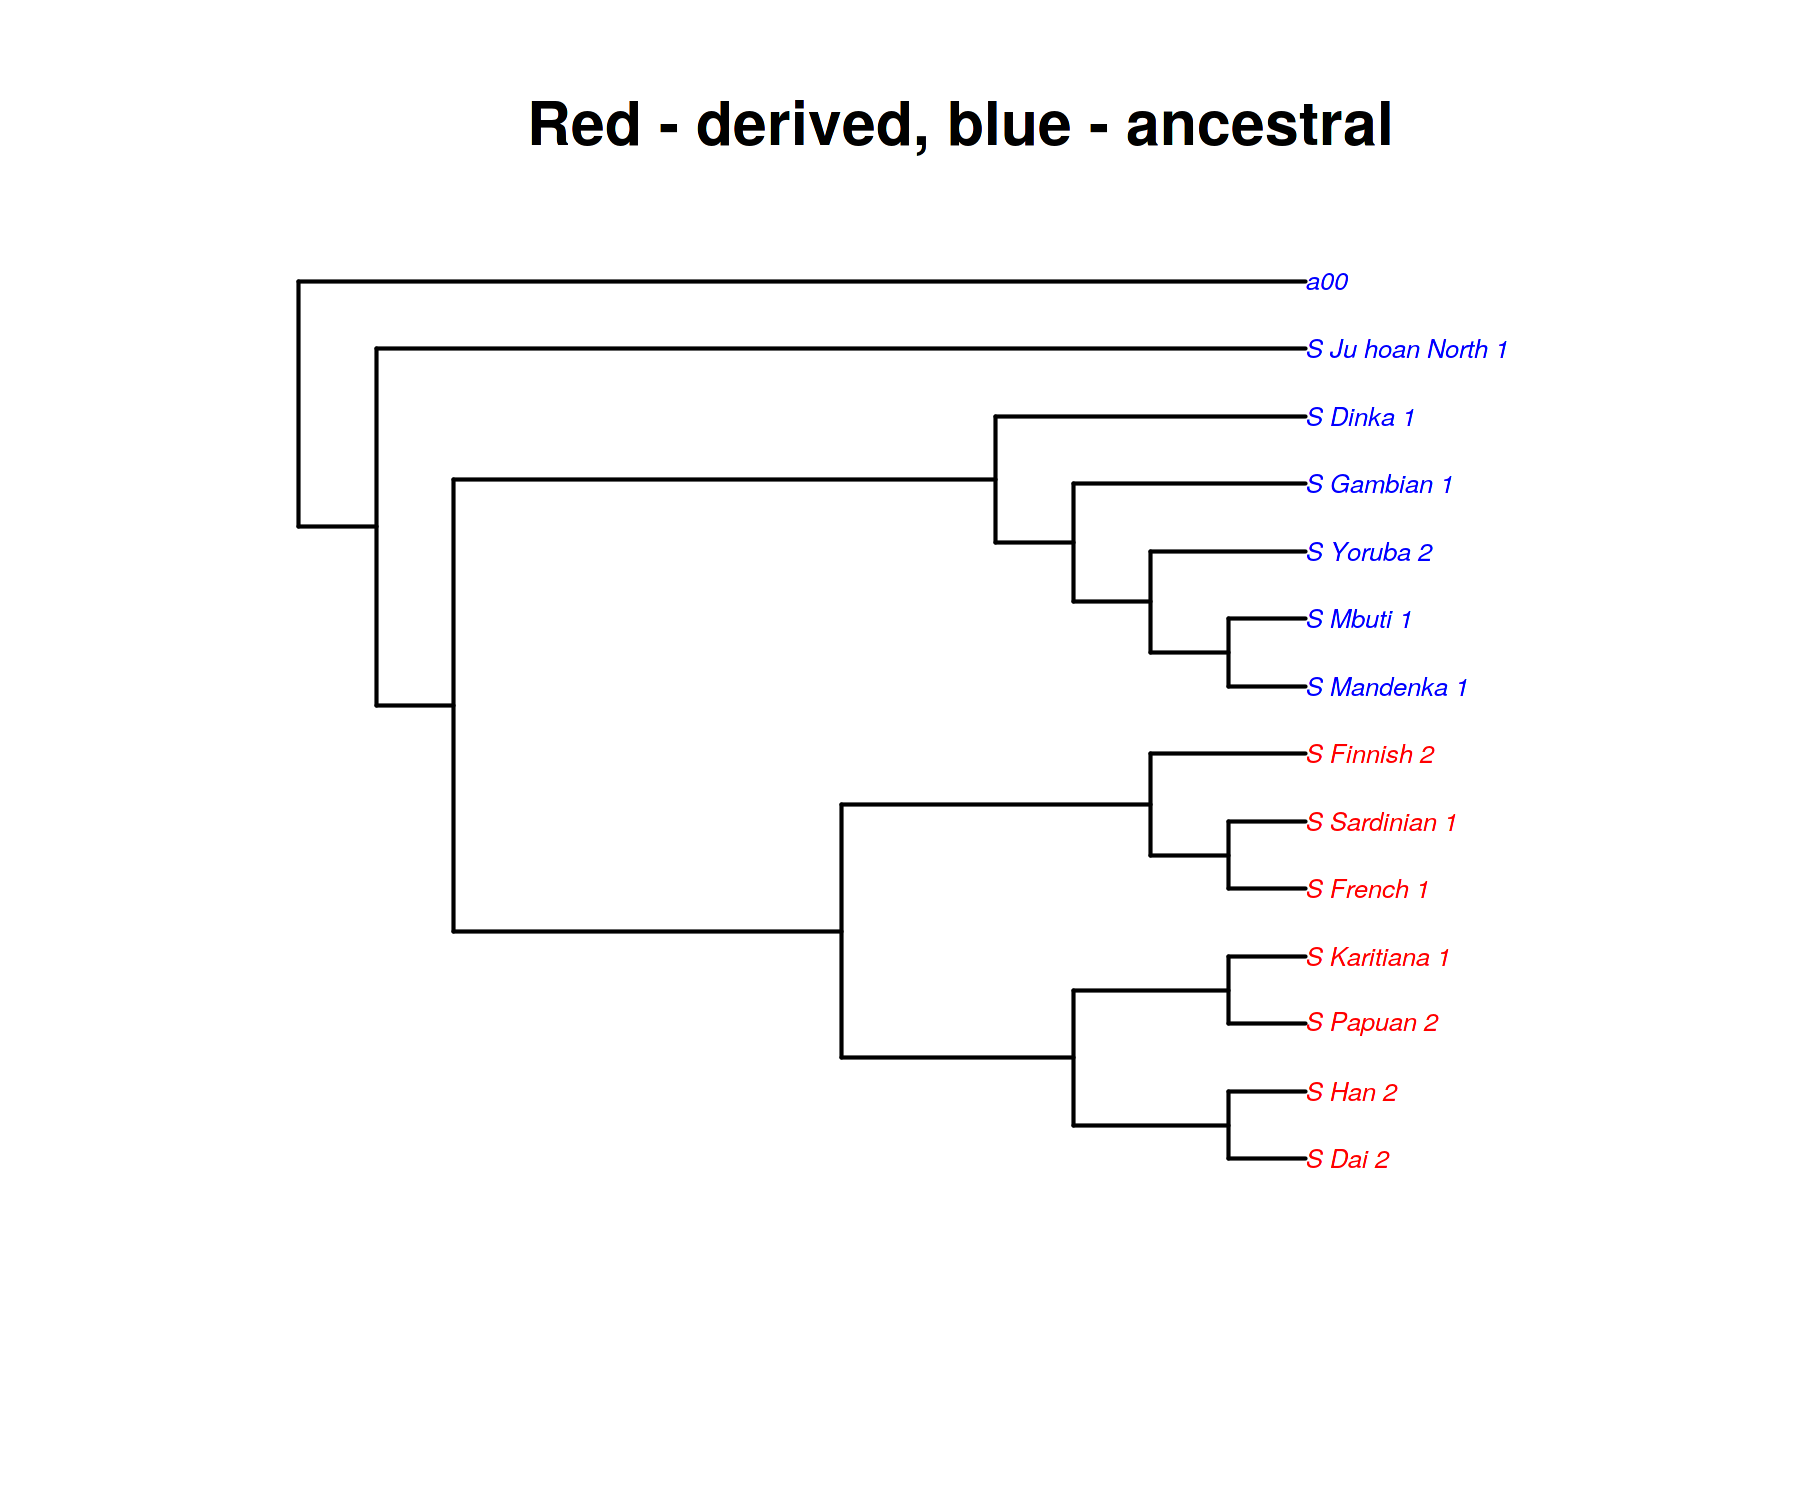

In [18]:
set_dim(6, 5, 300)

cols <- map_chr(rooted_tree$tip.label, ~ ifelse(.x %in% ingroup, "red", "blue"))

plot(rooted_tree, use.edge.length = FALSE, tip.color = cols, cex = 0.5)
title("Red - derived, blue - ancestral")

In [13]:
out_anc <- (rowMeans(derived[, outgroup]) == 0)
in_der <- (rowMeans(derived[, ingroup]) == 1)

In [14]:
derived[out_anc & in_der, ] %>% head

spy1,chimp,a00,S_BedouinB_1,S_Turkish_1,S_French_1,S_Burmese_1,S_Thai_1,S_Finnish_2,S_Sardinian_1,S_Han_2,S_Dai_2,S_Punjabi_1,S_Saami_2,S_Papuan_2,S_Karitiana_1,S_Ju_hoan_North_1
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [20]:
derived[out_anc & in_der, ] %>% filter(!is.na(spy1))

spy1,chimp,a00,S_BedouinB_1,S_Turkish_1,S_French_1,S_Burmese_1,S_Thai_1,S_Finnish_2,S_Sardinian_1,S_Han_2,S_Dai_2,S_Punjabi_1,S_Saami_2,S_Papuan_2,S_Karitiana_1,S_Ju_hoan_North_1
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0
0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0


In [15]:
fixed <- derived[out_anc & in_der, ] %>% select(-one_of(c(outgroup, ingroup)))

In [16]:
nrow(fixed)

[1] 1659

Proportion of sites in an aDNA sample carrying the derived allele shared with the <font color="red">red individuals</font>:

In [17]:
fixed %>% summarise_all(mean, na.rm = TRUE)

spy1,chimp
<dbl>,<dbl>
0.1,0


In [17]:
fixed %>% summarise_all(mean, na.rm = TRUE)

mez2,chimp
<dbl>,<dbl>
0.05854801,0


In [17]:
fixed %>% summarise_all(mean, na.rm = TRUE)

den8,chimp
<dbl>,<dbl>
0.09057971,0


In [16]:
fixed %>% summarise_all(mean, na.rm = TRUE)

spy1,chimp
<dbl>,<dbl>
0.1764706,0


In [22]:
fixed %>% summarise_all(mean, na.rm = TRUE)

chimp,spy1,mez2,neand,den8,ustishim,kk1,mota,bichon,loschbour
0,0,0,0,0,1,1,0,1,1


Total number of such informative sites:

In [23]:
fixed %>% summarise_all(~sum(!is.na(.x)))

chimp,spy1,mez2,neand,den8,ustishim,kk1,mota,bichon,loschbour
51,2,10,13,16,45,48,35,38,48


## Count MH contaminant SNPs using fixed A00&San ancestral vs derived non-A00&San sites

In [24]:
(outgroup <- c("a00", "S_Ju_hoan_North_1"))
(ingroup <- filter(pops, !pop %in% c("EMH", "reference"), !name %in% c("a00", "S_Ju_hoan_North_1"))$name)

[1] "a00"               "S_Ju_hoan_North_1"

[1] "S_BedouinB_1"  "S_Turkish_1"   "S_French_1"    "S_Burmese_1"  
 [5] "S_Thai_1"      "S_Finnish_2"   "S_Sardinian_1" "S_Han_2"      
 [9] "S_Dai_2"       "S_Punjabi_1"   "S_Saami_2"     "S_Papuan_2"   
[13] "S_Karitiana_1" "S_Dinka_1"     "S_Mbuti_1"     "S_Yoruba_2"   
[17] "S_Gambian_1"   "S_Mandenka_1"

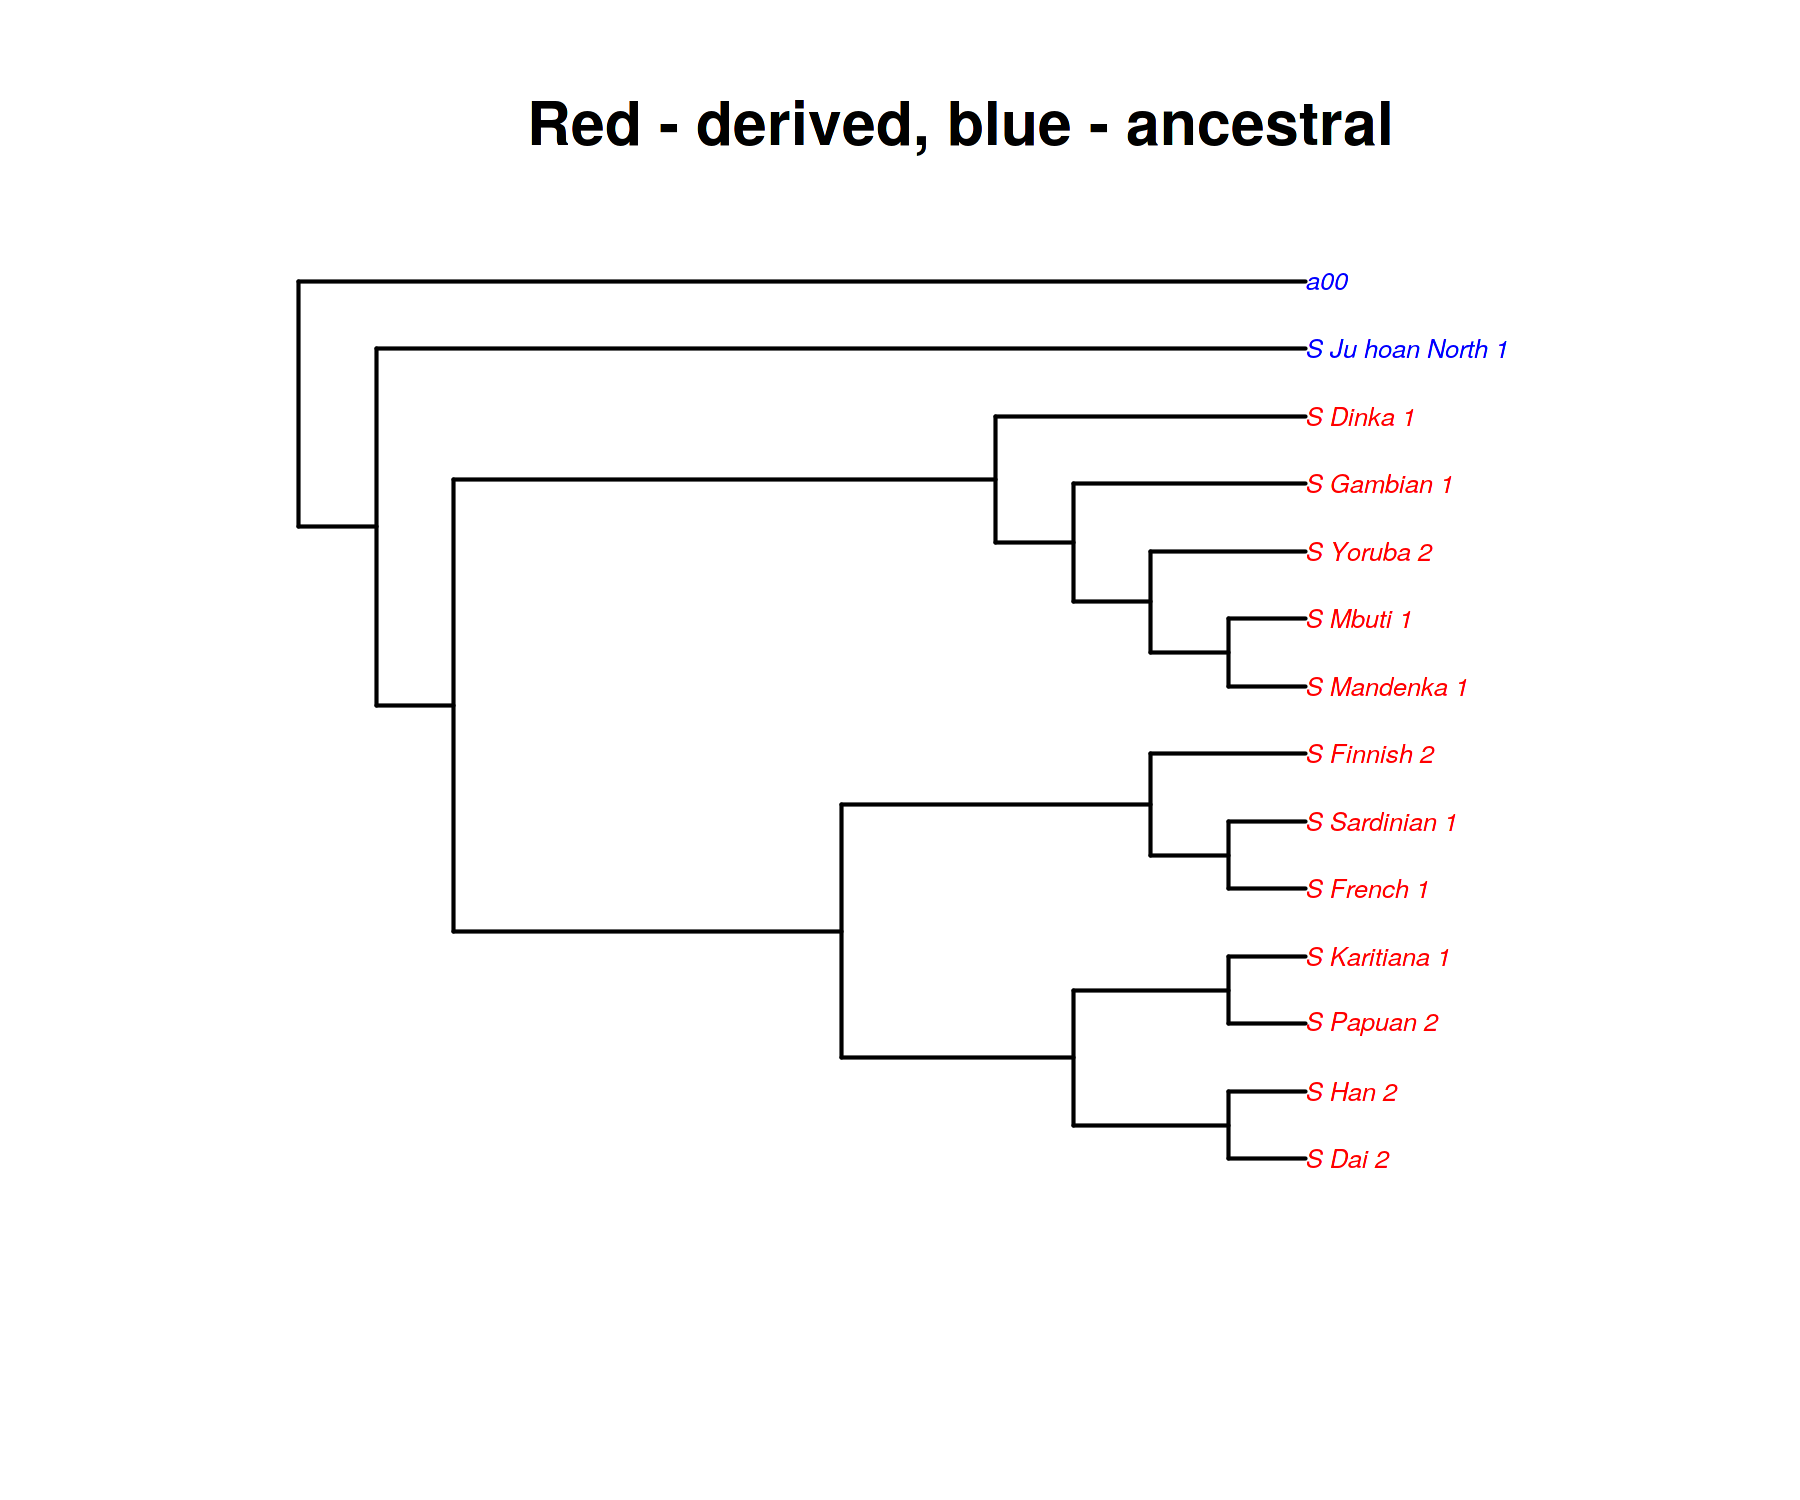

In [25]:
set_dim(6, 5, 300)

cols <- map_chr(rooted_tree$tip.label, ~ ifelse(.x %in% ingroup, "red", "blue"))

plot(rooted_tree, use.edge.length = FALSE, tip.color = cols, cex = 0.5)
title("Red - derived, blue - ancestral")

In [26]:
out_anc <- (rowMeans(derived[, outgroup]) == 0)
in_der <- (rowMeans(derived[, ingroup]) == 1)

In [27]:
fixed <- derived[out_anc & in_der, ] %>% select(-one_of(filter(pops, pop %in% c("Africa", "WestEur", "EastEur"))$name))

# dp >= 3

Proportion of sites in an aDNA sample carrying the derived allele shared with the <font color="red">red individuals</font>:

In [28]:
fixed %>% summarise_all(mean, na.rm = TRUE)

chimp,spy1,mez2,neand,den8,ustishim,kk1,mota,bichon,loschbour
0,0.2,0,0.05555556,0,1,1,1,1,1


Total number of such informative sites:

In [30]:
fixed %>% summarise_all(~sum(!is.na(.x)))

chimp,spy1,mez2,neand,den8,ustishim,kk1,mota,bichon,loschbour
90,5,10,18,38,85,72,78,67,86


# dp >= 4

In [29]:
fixed %>% summarise_all(mean, na.rm = TRUE)

chimp,spy1,mez2,neand,den8,ustishim,kk1,mota,bichon,loschbour
0,0,0,0,0,1,1,1,1,1


Total number of such informative sites:

In [30]:
fixed %>% summarise_all(~sum(!is.na(.x)))

chimp,spy1,mez2,neand,den8,ustishim,kk1,mota,bichon,loschbour
121,1,7,12,30,117,90,102,67,115


# Read-based contamination estimate

In [164]:
p <- read_tsv("../data/pileup//full_spy1.txt.gz", col_types = "cicciiii")

In [165]:
head(p)

chrom,pos,ref,pileup,A,C,G,T
Y,2649852,A,A,1,0,0,0
Y,2649853,T,T,0,0,0,1
Y,2649854,G,G,0,0,1,0
Y,2649855,G,G,0,0,1,0
Y,2649856,G,G,0,0,1,0
Y,2649857,C,C,0,1,0,0


In [166]:
select(gt, -chimp) %>% rowMeans(na.rm=T) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03448 0.04000 0.04167 0.08716 0.04762 0.96296 

In [167]:
(outgroup <- c("a00", "S_Ju_hoan_North_1"))
(ingroup <- filter(pops, !pop %in% c("EMH", "reference"), !name %in% c("a00", "S_Ju_hoan_North_1"))$name)

[1] "a00"               "S_Ju_hoan_North_1"

[1] "S_BedouinB_1"  "S_Turkish_1"   "S_French_1"    "S_Burmese_1"  
 [5] "S_Thai_1"      "S_Finnish_2"   "S_Sardinian_1" "S_Han_2"      
 [9] "S_Dai_2"       "S_Punjabi_1"   "S_Saami_2"     "S_Papuan_2"   
[13] "S_Karitiana_1" "S_Dinka_1"     "S_Mbuti_1"     "S_Yoruba_2"   
[17] "S_Gambian_1"   "S_Mandenka_1"

In [168]:
out_anc <- (rowMeans(derived[, outgroup]) == 0)
in_der <- (rowMeans(derived[, ingroup]) == 1)

In [169]:
genotypes <-  vcf[out_anc & in_der, ] %>% filter(!is.na(pos)) %>% select(-one_of(c(ingroup)))

In [170]:
df <- inner_join(genotypes, p, by = c("chrom", "pos", "REF" = "ref"))

In [173]:
nrow(df)

[1] 53

In [171]:
df %>% head

chrom,pos,REF,ALT,chimp,spy1,mez2,neand,den8,S_Ju_hoan_North_1,⋯,kk1,mota,bichon,loschbour,reference,pileup,A,C,G,T
Y,2744386,T,G,1,NA,NA,NA,NA,1,⋯,NA,0,NA,0,0,G,0,0,1,0
Y,6864267,G,A,1,NA,NA,NA,NA,1,⋯,0,0,0,0,0,A,1,0,0,0
Y,6991000,A,C,1,NA,NA,NA,1,1,⋯,0,0,0,0,0,T,0,0,0,1
Y,7153375,T,C,1,NA,NA,NA,NA,1,⋯,NA,0,0,0,0,CC,0,2,0,0
Y,7256433,T,A,1,NA,NA,NA,NA,1,⋯,NA,0,NA,0,0,A,1,0,0,0
Y,7740081,A,G,1,NA,NA,NA,NA,1,⋯,0,0,0,0,0,AG,1,0,1,0


In [132]:
filter(df, pos == 22850240)

chrom,pos,REF,ALT,chimp,spy1,mez2,neand,den8,S_Ju_hoan_North_1,⋯,kk1,mota,bichon,loschbour,reference,pileup,A,C,G,T
Y,22850240,G,A,1,NA,NA,NA,NA,1,⋯,0,0,NA,0,0,GGGGGGGGAGGGGGGGG,1,0,16,0


In [129]:
select(df, pos, REF, A, C, G, T) %>%
    mutate(n = A + C + G + T) %>%
    gather(base, count, -REF, -n, -pos) %>%
    filter(REF == base, count != n)

pos,REF,n,base,count
6864267,G,24,G,23
14308595,G,25,G,24
22850240,G,17,G,16
14079528,T,18,T,17


In [154]:
select(df, pos, REF, A, C, G, T) %>%
    mutate(n = A + C + G + T) %>%
    gather(base, count, -REF, -n, -pos) %>%
    filter(REF == base) %>%
    mutate(prop = count / n) %>%
    summarise_at(vars(prop), mean)

prop
0.04506692


In [163]:
select(df, pos, REF, A, C, G, T) %>%
    mutate(n = A + C + G + T) %>%
    gather(base, count, -REF, -n, -pos) %>%
    filter(REF == base) %>%
    mutate(prop = count / n) %>%
    summarise_at(vars(prop), mean)

prop
0.0399061


In [172]:
select(df, pos, REF, A, C, G, T) %>%
    mutate(n = A + C + G + T) %>%
    gather(base, count, -REF, -n, -pos) %>%
    filter(REF == base) %>%
    mutate(prop = count / n) %>%
    summarise_at(vars(prop), mean)

prop
0.06839623
